<a href="https://colab.research.google.com/github/jonkrohn/DLTFpT/blob/master/notebooks/dense_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN and LSTM Activity Classifier

In this notebook, we modify use CNN and LSTM layers to classify PE activity.

#### Load dependencies

In [135]:
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import Bidirectional, LeakyReLU, Flatten
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPool1D, GlobalAveragePooling1D, AveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint 
import os 
from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # new!

#### Set hyperparameters

In [185]:
# output directory name:
output_dir = 'model_output/lstm2'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/pocket/'
input_file_name = 'pocket-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency



# pooling layer parameters
maxpooling_pool_size = 2
avepooling_pool_size = 2


# convolutional layer architecture:
n_conv_1 = 512 # filters, a.k.a. kernels
k_conv_1 = 3 # kernel length
strides_1 = 1
n_conv_2 = 256
k_conv_2 = 3 # kernel length
n_conv_3 = 256 # filters, a.k.a. kernels
k_conv_3 = 2 # kernel length


# LSTM layer architecture:
n_lstm_1 = 128 
n_lstm_2 = 128 
n_lstm_3 = 64
drop_lstm_1 = 0.0
drop_lstm_2 = 0.02
drop_lstm_3 = 0.05


# dense layer architecture: 
n_dense_1 = 256
dropout_1 = 0.2
n_dense_2 = 256
dropout_2 = 0.3
n_dense_3 = 128
dropout_3 = 0.3

# training:
epochs = 60
batch_size = 256


#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [186]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [187]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']


#### Preprocess data

#### Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>




In [188]:
# change from string to integer so keras.to_categorical can consume it

# could do with factorize method as well
n_class = len(np.unique(labels_array))
class_list, labels_array_int = np.unique(labels_array,return_inverse=True)
labels_array_int

# check if the result is consistant with the original input
class_list[labels_array_int].reshape(len(labels_array_int), 1) == labels_array

# Note: to get the reverse, i.e converting integer array to string use class_list[labels_array_int]

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [189]:
# labels to categorical

y = to_categorical(labels_array_int, num_classes=n_class)
y.shape

(64754, 6)

In [190]:
input_shape = list(accel_array.shape)
input_shape

[64754, 90, 3]


#### Design neural network architecture

In [191]:
model = Sequential()
# model.add(MaxPool1D(pool_size = avepooling_pool_size, input_shape=input_shape[1:]))
model.add(Conv1D(n_conv_1, k_conv_1, activation=LeakyReLU(alpha=0.1), strides= strides_1, input_shape=input_shape[1:]))
model.add(MaxPool1D(pool_size = maxpooling_pool_size))
model.add(Conv1D(n_conv_2, k_conv_2, activation=LeakyReLU(alpha=0.1)))
model.add(AveragePooling1D(pool_size = avepooling_pool_size))
model.add(Conv1D(n_conv_3, k_conv_3, activation=LeakyReLU(alpha=0.1)))
# model.add(GlobalMaxPooling1D())
# model.add(GlobalAveragePooling1D())
model.add(LSTM(n_lstm_1, dropout=drop_lstm_1, 
                             return_sequences=True)) 
model.add(LSTM(n_lstm_2, dropout=drop_lstm_2, 
                             return_sequences=True))
model.add(LSTM(n_lstm_3, dropout=drop_lstm_3, 
                             return_sequences=True)) 
# model.add(Bidirectional(LSTM(n_lstm_2, dropout=drop_lstm_2)))
# model.add(GlobalMaxPooling1D())
# model.add(GlobalAveragePooling1D())
model.add(Flatten())
model.add(Dense(n_dense_1, activation=LeakyReLU(alpha=0.1)))
model.add(Dropout(dropout_1))
model.add(Dense(n_dense_2, activation=LeakyReLU(alpha=0.1)))
model.add(Dropout(dropout_2))
# model.add(Dense(n_dense_3, activation=LeakyReLU(alpha=0.1)))
# model.add(Dropout(dropout_3))
model.add(Dense(n_class, activation='softmax'))
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_52 (Conv1D)           (None, 88, 512)           5120      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 44, 512)           0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 42, 256)           393472    
_________________________________________________________________
average_pooling1d_15 (Averag (None, 21, 256)           0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 20, 256)           131328    
_________________________________________________________________
lstm_52 (LSTM)               (None, 20, 128)           197120    
_________________________________________________________________
lstm_53 (LSTM)               (None, 20, 128)         

### Splitting and shuffeling the data

In [192]:
# split and shuffle
x_train, x_valid, y_train, y_valid = train_test_split(
     accel_array, y, test_size=0.1, random_state=65)

#### Configure model

In [193]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [194]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

In [195]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [196]:
model.fit(x_train, y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=(x_valid, y_valid), 
         callbacks=[modelcheckpoint])

Epoch 1/60
228/228 [==============================] - 12s 51ms/step - loss: 1.1260 - accuracy: 0.5132 - val_loss: 0.9110 - val_accuracy: 0.6157
Epoch 2/60
228/228 [==============================] - 11s 48ms/step - loss: 0.8074 - accuracy: 0.6593 - val_loss: 0.7168 - val_accuracy: 0.7051
Epoch 3/60
228/228 [==============================] - 11s 48ms/step - loss: 0.6384 - accuracy: 0.7475 - val_loss: 0.4835 - val_accuracy: 0.8028
Epoch 4/60
228/228 [==============================] - 11s 48ms/step - loss: 0.4529 - accuracy: 0.8162 - val_loss: 0.5139 - val_accuracy: 0.8044
Epoch 5/60
228/228 [==============================] - 11s 48ms/step - loss: 0.3966 - accuracy: 0.8413 - val_loss: 0.3521 - val_accuracy: 0.8562
Epoch 6/60
228/228 [==============================] - 11s 48ms/step - loss: 0.3579 - accuracy: 0.8587 - val_loss: 0.6924 - val_accuracy: 0.7769
Epoch 7/60
228/228 [==============================] - 11s 48ms/step - loss: 0.3731 - accuracy: 0.8573 - val_loss: 0.3763 - val_accuracy:

228/228 [==============================] - 11s 49ms/step - loss: 0.0825 - accuracy: 0.9707 - val_loss: 0.2204 - val_accuracy: 0.9469
Epoch 58/60
228/228 [==============================] - 11s 49ms/step - loss: 0.0782 - accuracy: 0.9712 - val_loss: 0.2124 - val_accuracy: 0.9495
Epoch 59/60
228/228 [==============================] - 11s 49ms/step - loss: 0.0757 - accuracy: 0.9728 - val_loss: 0.2055 - val_accuracy: 0.9521
Epoch 60/60
228/228 [==============================] - 11s 49ms/step - loss: 0.0746 - accuracy: 0.9735 - val_loss: 0.2193 - val_accuracy: 0.9453


#### Evaluate

In [38]:
model.load_weights(output_dir+"/weights.49.hdf5") # 94.22 val accuracy

In [75]:
y_hat = model.predict(x_valid)

In [76]:
len(y_hat)

6476

In [77]:
y_hat[0]

array([3.96524119e-04, 1.13680684e-07, 5.38404549e-07, 2.49315212e-06,
       1.73458429e-05, 9.99582946e-01], dtype=float32)

In [78]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

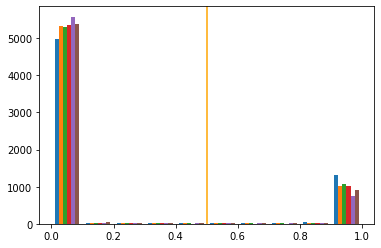

In [79]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [80]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [81]:
"{:0.2f}".format(pct_auc)

'99.70'

In [82]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [83]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [84]:
ydf.head(10)

,y_hat,y
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
5,"[0.012, 0.0, 0.0, 0.0, 0.0, 0.988]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
